# **HỆ THỐNG GỢI Ý (RECOMMENDER SYSTEMS)**
---
Dự án này sẽ xây dựng một hệ thống đề xuất dựa trên tập dữ liệu Movies.

![alt text](https://miro.medium.com/max/638/1*10sfQufkGnB-fWbBaNK8rg.jpeg)

Dựa vào dữ liệu của trên 45000 bộ film, xây dựng hệ thống đề xuất đưa ra danh sách 15 bộ film liên quan. Có hai loại Recommender system được xây dựng trong project này:


*   Simple Recommender
*   Content-Based Recommender

Các file dữ liệu sử dụng bao gồm:

**movies_metadata.csv:** File này chứa thông tin tổng hợp của 45 466 bộ film, mỗi bộ film có 24 thuộc tính khác nhau, một số thuộc tính chính bao gồm:

1. adult: Bộ film dành cho người lớn hay không. Dữ liệu boolean (True - Flase)
2. original_language: Ngôn ngữ ban đầu; dữ liệu categorical
3. original_title: Tiêu đề của film, dữ liệu text
4. overview: Tóm tắt nội dung của film; Dữ liệu text
5. vote_average: Tỷ lệ vote trung bình [0-10]
6. vote_count: Số lượt vote


Theo bài viết: [Recommender Systems in Python: Beginner Tutorial](https://www.datacamp.com/community/tutorials/recommender-systems-python)

---
dangvannam@Department of Computer Science@2020

# I) Đọc tập dữ liệu Movie
---

In [2]:
#Thực hiện mount tới drive chứa file dữ liệu của Project
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
#Đọc tập dữ liệu thông tin của các film
path='/content/drive/My Drive/Colab Notebooks/10Project/Data6_RecommenderSystem/movies_metadata.csv'
data_movies = pd.read_csv(path)
#Hiển thị thông tin tập dữ liệu
data_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [72]:
#Hiển thị dữ liệu 5 dòng đầu tiên
data_movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


**Lọc dữ liệu thô ban đầu chỉ lấy các cột quan trọng sử dụng để xây dựng hệ thống gợi ý:**
* adult: Bộ film dành cho người lớn hay không. Dữ liệu boolean (True - Flase)
* original_language: Ngôn ngữ ban đầu; dữ liệu categorical
* original_title: Tiêu đề của film, dữ liệu text
* overview: Tóm tắt nội dung của film; Dữ liệu text
* release_date: Ngày phát hành film
* vote_average: Tỷ lệ vote trung bình [0-10]
* vote_count: Số lượt vote

In [10]:
data = data_movies.loc[:,['adult','original_title','overview','release_date','vote_average','vote_count']].copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   adult           45466 non-null  object 
 1   original_title  45466 non-null  object 
 2   overview        44512 non-null  object 
 3   release_date    45379 non-null  object 
 4   vote_average    45460 non-null  float64
 5   vote_count      45460 non-null  float64
dtypes: float64(2), object(4)
memory usage: 2.1+ MB


In [6]:
#Đặc trưng thống kê các thuôc tính số
data.describe()

,vote_average,vote_count
count,45460.000000,45460.000000
mean,5.618207,109.897338
std,1.924216,491.310374
min,0.000000,0.000000
25%,5.000000,3.000000
50%,6.000000,10.000000
75%,6.800000,34.000000
max,10.000000,14075.000000


In [11]:
#Đặc trưng thống kê dữ liệu Object
data.describe(include=['O'])

,adult,original_title,overview,release_date
count,45466,45466,44512,45379
unique,5,43373,44307,17336
top,False,Alice in Wonderland,No overview found.,2008-01-01
freq,45454,8,133,136


# **2) Tiền xử lý dữ liệu tập Movies**
---

## **2.1) Chuẩn hóa dữ liệu:**
---
* Kiểm tra dữ liệu null của các thuộc tính
* Loại bỏ các bộ film có thuộc tín null
* Sắp xếp lại các bộ film theo ngày phát hành

In [12]:
#Thống kê số liệu missing trong Data frame
#Theo từng cột
print('Số lượng missing data trong file dữ liệu:')
print(data.isnull().sum())

Số lượng missing data trong file dữ liệu:
adult               0
original_title      0
overview          954
release_date       87
vote_average        6
vote_count          6
dtype: int64


In [13]:
#Xóa tất cả các bộ film có chứ thuộc tính null
data.dropna(axis=0,how='any',inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44435 entries, 0 to 45465
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   adult           44435 non-null  object 
 1   original_title  44435 non-null  object 
 2   overview        44435 non-null  object 
 3   release_date    44435 non-null  object 
 4   vote_average    44435 non-null  float64
 5   vote_count      44435 non-null  float64
dtypes: float64(2), object(4)
memory usage: 2.4+ MB


In [17]:
#Sắp xếp lại dữ liệu theo ngày phát hành
data.sort_values('release_date',axis=0,inplace=True)
data.head()

,adult,original_title,overview,release_date,vote_average,vote_count
34940,False,Passage de Venus,Photo sequence of the rare transit of Venus ov...,1874-12-09,6.0,19.0
34937,False,Sallie Gardner at a Gallop,Sallie Gardner at a Gallop was one of the earl...,1878-06-14,6.2,25.0
41602,False,Buffalo Running,Individual photographs of the running of a buf...,1883-11-19,5.4,7.0
34933,False,Man Walking Around a Corner,The last remaining production of Le Prince's L...,1887-08-18,4.1,17.0
34934,False,Accordion Player,The last remaining film of Le Prince's LPCCP T...,1888-01-01,4.4,18.0


In [18]:
data.tail()

,adult,original_title,overview,release_date,vote_average,vote_count
44535,False,Mobile Homes,"In forgotten towns along the American border, ...",2018-04-04,0.0,1.0
38130,False,Mary Shelley,The love affair between poet Percy Shelley and...,2018-04-25,0.0,1.0
30402,False,Bad Boys for Life,The continuing adventures of Miami detectives ...,2018-11-07,0.0,12.0
38885,False,The Other Side of the Wind,"Orson Welles' unfinished masterpiece, restored...",2018-12-31,0.0,1.0
26559,False,Avatar 2,A sequel to Avatar (2009).,2020-12-16,0.0,58.0


In [14]:
#Các giá trị khác nhau của thuộc tính adult
data.adult.value_counts()

False    44427
True         8
Name: adult, dtype: int64

In [21]:
#Lọc các bộ film cho người trưởng thành
print(data[data['adult']=='True'].loc[:,['original_title','overview']])

                            original_title                                           overview
19489  Le notti erotiche dei morti viventi  A sailor takes an American businessman and his...
28701                             Standoff  The FBI and Texas police make ready to storm t...
31934                                發電悄嬌娃  Electrical Girl centers around a horny young w...
32113                          Diet of Sex  Ágata suffers from a psychological disorder wh...
39901           Amateur Porn Star Killer 2  Shane Ryan's sequel to the disturbing Amateur ...
39902                             The Band  Australian film about a fictional sub-par Aust...
40574                              Dværgen  Olaf and his mother run a boarding house and a...
41009                           Adulterers  A man who returns home to find his wife cheati...
43090                           Half -Life  An American scientific research facility opens...


In [20]:
#Lưu dữ liệu đã xử lý ra file .csv
data.to_csv('Data_Movies_1.csv',index=None)

## **2.2) Loại bỏ các bộ film trùng tên trong tập dữ liệu**
---
Thực hiện xóa các bộ film trùng tên trong tập dữ liệu chỉ giữ lại bộ film có số lượng vote cao nhất

In [21]:
#Thống kê các bộ film trùng tên trong tập dữ liệu
data['original_title'].value_counts()

Hamlet                 8
Alice in Wonderland    8
A Christmas Carol      7
Cinderella             7
Les Misérables         7
                      ..
La libertad            1
Riding Giants          1
The Debut              1
The Sundowners         1
Pure Country           1
Name: original_title, Length: 42374, dtype: int64

In [22]:
data.loc[data['original_title']=='Hamlet']

,adult,original_title,overview,release_date,vote_average,vote_count
1832,False,Hamlet,"Winner of four Academy Awards, including Best ...",1948-03-25,7.1,48.0
18061,False,Hamlet,Tony Richardson's Hamlet is based on his own s...,1969-12-21,6.1,7.0
21239,False,Hamlet,Hamlet comes home from university to find his ...,1980-05-25,4.0,3.0
3601,False,Hamlet,"Hamlet, Prince of Denmark, finds out that his ...",1990-12-19,6.7,95.0
1360,False,Hamlet,"Hamlet, Prince of Denmark, returns home to fin...",1996-12-25,7.3,118.0
3476,False,Hamlet,Modern day adaptation of Shakespeare's immorta...,2000-05-12,6.0,35.0
13313,False,Hamlet,"To be or not to be, etc.",2000-12-10,0.0,0.0
18908,False,Hamlet,David Tennant stars in a film of the Royal Sha...,2009-12-26,7.3,22.0


In [23]:
data.sort_values('vote_count',ascending=True,inplace=True)
data.drop_duplicates(['original_title'],keep='last',inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42374 entries, 42742 to 15480
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   adult           42374 non-null  object 
 1   original_title  42374 non-null  object 
 2   overview        42374 non-null  object 
 3   release_date    42374 non-null  object 
 4   vote_average    42374 non-null  float64
 5   vote_count      42374 non-null  float64
dtypes: float64(2), object(4)
memory usage: 2.3+ MB


In [25]:
#check lại dữ liệu sau khi xử lý
data.loc[data['original_title']=='Hamlet']

,adult,original_title,overview,release_date,vote_average,vote_count
1360,False,Hamlet,"Hamlet, Prince of Denmark, returns home to fin...",1996-12-25,7.3,118.0


In [26]:
#Thống kê các bộ film trùng tên trong tập dữ liệu sau xử lý
data['original_title'].value_counts()

Delphine 1, Yvan 0                        1
Saved by the Bell: Hawaiian Style         1
Un singe en hiver                         1
Supermensch: The Legend of Shep Gordon    1
Il profumo della signora in nero          1
                                         ..
Lili                                      1
Trevor Noah: Afraid of the Dark           1
Solomennaya Shlyapka                      1
Cult of the Cobra                         1
Kollegiet                                 1
Name: original_title, Length: 42374, dtype: int64

## **2.3) Xử lý các bộ film không có tóm tắt film**
---

In [27]:
#Thống kê các dữ liệu trùng nhau
data['overview'].value_counts()

No overview found.                                                                                                                                                                                                                                                                                                                                                             131
No Overview                                                                                                                                                                                                                                                                                                                                                                      7
                                                                                                                                                                                                                                                                  

In [28]:
#lọc các bộ film có phần tóm tắt là: No overview found, hoặc No Overview, hoăc chuỗi rỗng, hoặc No movie overview available. 
data.loc[(data['overview']=='No overview found.') 
| (data['overview']=='No Overview')
| (data['overview']==' ')
| (data['overview']=='No movie overview available.')  ].sort_values('overview')

,adult,original_title,overview,release_date,vote_average,vote_count
28408,False,Αυστηρώς Κατάλληλο,,2008-10-23,7.5,4.0
18171,False,Sur,,1988-01-01,3.7,3.0
4246,False,Snow days,,1999-01-01,5.0,1.0
34919,False,Iceland,,1942-09-21,0.0,0.0
4538,False,Slaves of New York,,1989-03-18,4.8,6.0
...,...,...,...,...,...,...
39207,False,Clair de femme,No overview found.,1979-08-29,6.5,2.0
38128,False,Wizards of the Lost Kingdom II,No overview found.,1989-03-01,2.5,2.0
36970,False,Dil Dosti Etc,No overview found.,2007-09-28,6.5,2.0
41806,False,Kleinruppin forever,No overview found.,2004-02-08,6.0,3.0


In [30]:
#Có tất cả 146 bộ film không có dữ liệu tóm tắt film
#Xóa các bộ film này
data = data.loc[(data['overview']!='No overview found.') 
& (data['overview']!='No Overview')
& (data['overview']!=' ')
& (data['overview']!='No movie overview available.')]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42228 entries, 42742 to 15480
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   adult           42228 non-null  object 
 1   original_title  42228 non-null  object 
 2   overview        42228 non-null  object 
 3   release_date    42228 non-null  object 
 4   vote_average    42228 non-null  float64
 5   vote_count      42228 non-null  float64
dtypes: float64(2), object(4)
memory usage: 2.3+ MB


In [31]:
#Check lại dữ liệu sau khi xử lý phần tóm tắt
data['overview'].value_counts()

A few funny little novels about different aspects of life.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   3
An abstract animation from Walter Ruttmann.                                                                                                                                                                                                                                                                                                                                              

In [33]:
data.loc[(data['overview']=='A few funny little novels about different aspects of life.')]

,adult,original_title,overview,release_date,vote_average,vote_count
30160,False,Le nuove comiche,A few funny little novels about different aspe...,1994-01-01,5.0,32.0
30158,False,Le comiche 2,A few funny little novels about different aspe...,1991-10-19,5.5,47.0
30156,False,Le comiche,A few funny little novels about different aspe...,1990-01-01,5.7,59.0


## **2.4) Lưu dữ liệu sau khi đã xử lý ra file**
---

In [34]:
data.to_csv('Data_Movies_ok.csv',index=None)

In [35]:
data.reset_index(drop=True,inplace=True)
data.head()

,adult,original_title,overview,release_date,vote_average,vote_count
0,False,Margaret Cho: PsyCHO,Three-time Grammy and Emmy nominated comedian ...,2015-09-25,0.0,0.0
1,False,Hamlet at Elsinore,Christopher Plummer is joined by an all-star c...,1964-11-15,0.0,0.0
2,False,Gli invincibili tre,"(1964) Alan Steel, Lisa Gastoni, Mimmo Palmara...",1964-11-26,0.0,0.0
3,False,The Secret of Blood Island,Based on the true story of a British secret ag...,1964-12-01,0.0,0.0
4,False,Reiruweizu: 49-sai de densha no untenshi ni na...,The Story of a Man Who Became a Train Operator...,2010-05-29,0.0,0.0


# **3) Xây dựng các hệ thống Recommender Systems**
---
Recommender systems có thể phân thành 3 loại như sau:

* **Hệ thống đề xuất dựa trên nội dung (Content-based recommenders):** Hệ thống này sẽ gợi ý các bộ phim tương tự với bộ fim mà người dùng xem. Hệ thống này sử dụng metadata của các bộ film như: Thể loại film, đạo diễn, mô tả film, diễn viên...Ý tưởng chính đằng sau hệ thống đề xuất dựa vào nội dung đó là nếu một người đã thích/xem một bộ film nào đó, thì họ cũng sẽ thích/xem một bộ phim tương tự với bộ phim đã xem. 


* **Hệ thống lọc cộng tác (Collaborative filtering engines):** Hệ thống này cố gắng dự đoán thông qua đánh giá hoặc ưa thích mà một người dùng đã đưa ra đối với một bộ film dựa trên đnhs giá và ưa thích của những người sử dụng khác. Lọc cộng tác không yêu cầu metadata giống như lọc theo nội dung. (Tìm một người xem có các thuộc tính tương đồng với người dùng này và đề xuất các bộ film theo người xem trước đây)

* **Hệ thống lai (Hybrid Engine):** Kết hợp các ý tưởng của Content-based recommender và Collaborative filtering để xây dựng một hệ thống đề xuất.

![alt text](https://data-flair.training/blogs/wp-content/uploads/sites/2/2019/07/data-science-movie-recommendation-project.jpg)

## **3.1) Simple Recommenders (Giải quyết trường hợp Cold-Start Problem)**
---
Lọc ra  15 bộ film (các bộ film nổi bật) trong danh sách film có trong CSDL có tỷ lệ người đánh giá và điểm đánh giá cao để đề xuất cho người dùng xem.

![alt text](https://user-images.githubusercontent.com/42392773/52229643-67723e80-28db-11e9-8ef8-4ddd945a34cd.jpg)

Các bộ film được tính trọng số đánh giá (Weighted Rating - WR), và dựa vào trọng số này để lọc ra danh sách các bộ film nổi bật đề xuất cho người xem.



Tính Weighted Rating (WR):

**WR = {[v/(v+m) . R] + [m/(v+m) . C]}**

* v: Số lượng người vote cho bộ film đó
* m: Số lượng người vote tối thiểu yêu cầu đối với 1 bộ film 
* R: Vote trung bình của bộ film đó
* C: vote trung bình của tất cả các bộ film trong tập dữ liệu


In [36]:
#Hiển thị dữ liệu sau khi đã tiền xử lý
data.head()

,adult,original_title,overview,release_date,vote_average,vote_count
0,False,Margaret Cho: PsyCHO,Three-time Grammy and Emmy nominated comedian ...,2015-09-25,0.0,0.0
1,False,Hamlet at Elsinore,Christopher Plummer is joined by an all-star c...,1964-11-15,0.0,0.0
2,False,Gli invincibili tre,"(1964) Alan Steel, Lisa Gastoni, Mimmo Palmara...",1964-11-26,0.0,0.0
3,False,The Secret of Blood Island,Based on the true story of a British secret ag...,1964-12-01,0.0,0.0
4,False,Reiruweizu: 49-sai de densha no untenshi ni na...,The Story of a Man Who Became a Train Operator...,2010-05-29,0.0,0.0


In [37]:
# Tính C
C = data['vote_average'].mean()
print(C)

5.6616036752866075


In [38]:
#Số lượng người vote tối thiểu cho một bộ film phải từ 1000 người trở lên
#Lọc các film có vote_count > m thành một DataFrame mới
m=1000
movies_vote_1000 = data.copy().loc[data['vote_count']>=m]
movies_vote_1000.head()

,adult,original_title,overview,release_date,vote_average,vote_count
41119,False,Final Destination 3,A student's premonition of a deadly rollercoas...,2006-02-10,5.8,1000.0
41120,False,Goldfinger,Special agent 007 (Sean Connery) comes face to...,1964-09-17,7.2,1005.0
41121,False,Insidious: Chapter 3,A twisted new tale of terror begins for a teen...,2015-06-04,6.3,1005.0
41122,False,The Ugly Truth,A romantically challenged morning show produce...,2009-07-24,6.4,1005.0
41123,False,One Day,"A romantic comedy centered on Dexter and Emma,...",2011-03-02,7.0,1006.0


In [39]:
print('Data ban đầu:',data.shape)
print('Data film có vote_count>1000:', movies_vote_1000.shape)

Data ban đầu: (42228, 6)
Data film có vote_count>1000: (1109, 6)


In [40]:
#Hiển thị dữ liệu thống kê cho thuộc tính vote_average, vote_count
movies_vote_1000.describe()

,vote_average,vote_count
count,1109.000000,1109.000000
mean,6.774031,2538.054103
std,0.744869,1797.099646
min,4.100000,1000.000000
25%,6.200000,1340.000000
50%,6.700000,1857.000000
75%,7.300000,3082.000000
max,8.500000,14075.000000


Tập dữ liệu ban đầu có 42 228 bộ film, sau khi lọc chỉ lấy những bộ film có tổng số lượt vote từ 1000 lần trở lên, có tất cả 1109 bộ film thỏa mãn, lưu sang Dataframe mới có tên: movie_vote_1000

In [41]:
# Xây dựng hàm tính trọng số đánh giá WR
def wr(x,m=m,C=C):
    v=x['vote_count']
    R=x['vote_average']
    return (v/(v+m)*R) + (m/(m+v)*C)

In [42]:
#Thêm một thuộc tính mới cho mỗi bộ film  'score', lưu giá trị Weighted_rating tương ứng
movies_vote_1000['score'] =  movies_vote_1000.apply(wr,axis=1)
movies_vote_1000.head()

,adult,original_title,overview,release_date,vote_average,vote_count,score
41119,False,Final Destination 3,A student's premonition of a deadly rollercoas...,2006-02-10,5.8,1000.0,5.730802
41120,False,Goldfinger,Special agent 007 (Sean Connery) comes face to...,1964-09-17,7.2,1005.0,6.432720
41121,False,Insidious: Chapter 3,A twisted new tale of terror begins for a teen...,2015-06-04,6.3,1005.0,5.981598
41122,False,The Ugly Truth,A romantically challenged morning show produce...,2009-07-24,6.4,1005.0,6.031723
41123,False,One Day,"A romantic comedy centered on Dexter and Emma,...",2011-03-02,7.0,1006.0,6.332803


In [43]:
#Sắp xếp lại dữ liệu theo score giảm dần và lọc ra 15 film có score cao nhất
movies_vote_1000=movies_vote_1000.sort_values('score',ascending=False)
movies_vote_1000

,adult,original_title,overview,release_date,vote_average,vote_count,score
42208,False,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,1994-09-23,8.5,8358.0,8.196688
42226,False,The Dark Knight,Batman raises the stakes in his war on crime. ...,2008-07-16,8.3,12269.0,8.101161
42166,False,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",1972-03-14,8.5,6024.0,8.095900
42219,False,Fight Club,A ticking-time-bomb insomniac and a slippery s...,1999-10-15,8.3,9678.0,8.052913
42210,False,Pulp Fiction,"A burger-loving hit man, his philosophical par...",1994-09-10,8.3,8670.0,8.027157
...,...,...,...,...,...,...,...
41272,False,Ghost Rider: Spirit of Vengeance,When the devil resurfaces with aims to take ov...,2011-12-10,4.7,1163.0,5.144569
41282,False,The Last Airbender,"The story follows the adventures of Aang, a yo...",2010-06-30,4.7,1180.0,5.141103
41862,False,Independence Day: Resurgence,We always knew they were coming back. Using re...,2016-06-22,4.9,2550.0,5.114536
41158,False,The Boy Next Door,A recently cheated on married woman falls for ...,2015-01-23,4.1,1034.0,4.867750


In [44]:
#Lấy 15 film có điểm trọng số đánh giá cao nhất
list15 = movies_vote_1000[['original_title','vote_count','vote_average','score']].head(15)
list15.reset_index(inplace=True)
list15.drop('index',axis=1,inplace=True)
print('DANH SÁCH 15 BỘ FILM CÓ ĐIỂM ĐÁNH GIÁ (score) CAO NHẤT')
list15

DANH SÁCH 15 BỘ FILM CÓ ĐIỂM ĐÁNH GIÁ (score) CAO NHẤT


,original_title,vote_count,vote_average,score
0,The Shawshank Redemption,8358.0,8.5,8.196688
1,The Dark Knight,12269.0,8.3,8.101161
2,The Godfather,6024.0,8.5,8.095900
3,Fight Club,9678.0,8.3,8.052913
4,Pulp Fiction,8670.0,8.3,8.027157
5,Inception,14075.0,8.1,7.938249
6,Forrest Gump,8147.0,8.2,7.922489
7,Interstellar,11187.0,8.1,7.899918
8,The Empire Strikes Back,5998.0,8.2,7.837268
9,The Lord of the Rings: The Return of the King,8226.0,8.1,7.835704


Sau khi tính toán trọng số đánh giá (WR), dựa vào thông số này để đưa ra danh sách các film (có trọng số đánh giá cao) gợi ý cho người xem. Ví dụ trong trường hợp ở trên chúng ta đưa ra 15 bộ phim có trọng số đánh giá cao nhất.

WR phụ thuộc vào vote trung bình của bộ phim đó với lượng người vote cho bộ film. Có những bộ film có vote trung bình cao nhưng lượng người vote lại ít nên WR thấp.

Một số bộ film có điểm vote trung bình bằng 10 (max) = 190 film, nhưng số lượt vote lại rất thấp (1 hoặc 2 lượt vote) nên ko được đưa vào danh sách tính WR (<1000 lượt vote)

In [45]:
#Số lượng các film có vote trung bình bằng 10
data[data['vote_average']>=10].count()

adult             168
original_title    168
overview          168
release_date      168
vote_average      168
vote_count        168
dtype: int64

In [46]:
#Danh sách các film có vote trung bình bằng 10
data[data['vote_average']>=10].loc[:,['original_title','vote_average','vote_count']]

,original_title,vote_average,vote_count
2494,Elaine Stritch: At Liberty,10.0,1.0
2509,"The Haunted World of Edward D. Wood, Jr.",10.0,1.0
2555,Summer City,10.0,1.0
2556,The Union,10.0,1.0
2587,Harold and Lillian: A Hollywood Love Story,10.0,1.0
...,...,...,...
9220,Avetik,10.0,3.0
9548,Майдан,10.0,3.0
10278,Mera Naam Joker,10.0,3.0
10545,Mariposa,10.0,3.0


## **3.2) Content-Based Recommender:**
---
Với hệ thống đề xuất dựa trên nội dung, nhiệm vụ của chúng ta là phải tìm được một bộ film có nội dung tương đồng cao nhất với một bộ film xác định. 

Chúng ta sẽ phải tính toán số điểm tương đồng theo từng cặp cho tất cả các bộ film và đưa ra bộ film đề xuất có điểm tương đồng cao nhất.


### A) Dựa vào tóm tắt film (Overview)
---
Dữ liệu film có thuộc tính "overview" đây là thuộc tính tóm tắt nội dung của bộ film. Chúng ta sẽ dựa vào thông tin tóm tắt film để tìm bộ film có nội dung tương tự với bộ film đưa vào.

* Sử dụng phương pháp vertor hóa: TF-IDF


In [47]:
#Dữ liệu các bộ fim ban đâu
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42228 entries, 0 to 42227
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   adult           42228 non-null  object 
 1   original_title  42228 non-null  object 
 2   overview        42228 non-null  object 
 3   release_date    42228 non-null  object 
 4   vote_average    42228 non-null  float64
 5   vote_count      42228 non-null  float64
dtypes: float64(2), object(4)
memory usage: 1.9+ MB


Sử dụng TF-IDF để đánh giá độ tương đồng giữa 2 bộ film dựa vào phần tóm tắt nội dung film.


In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Định nghĩa một vector TF-IDF loại bỏ tất cả các stop words trong TA
tfidf = TfidfVectorizer(stop_words='english')

In [51]:
#Xây dựng ma trận TF-IDF
tfidf_matrix = tfidf.fit_transform(data['overview'])
# ma trận corpus của TFIDF
tfidf_matrix.shape

(42228, 74525)

Có tất cả 75525 từ khác nhau (ko kể các stop words) được sử dụng để tóm tắt nội dung của 42228 bộ film. Dựa vào tâp corpus này chúng ta sẽ thực hiện việc tính toán độ tương đồng. Có thể sử dụng các độ đo như:
* Euclidean distance. 
* Cosine distance.

Câu hỏi đặt ra là độ đo tương đồng nào là tốt nhất? ko có độ đo nào là tốt nhất nó phụ thuộc vào từng loại dữ liệu và bài toán cụ thể. 

Chúng ta sẽ sử dụng độ đo Cosine để tính độ tương đồng:

![alt text](https://sites.temple.edu/tudsc/files/2017/03/cosine-equation.png)

In [52]:
from sklearn.metrics.pairwise import linear_kernel

#Tính độ tương tự cosine giữa các bộ film với nhau dựa vào tóm tắt film
cosine_sim = linear_kernel(tfidf_matrix,tfidf_matrix)
print(cosine_sim.shape)
print(cosine_sim)

(42228, 42228)
[[1.         0.         0.01036131 ... 0.         0.         0.        ]
 [0.         1.         0.01332987 ... 0.         0.         0.        ]
 [0.01036131 0.01332987 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


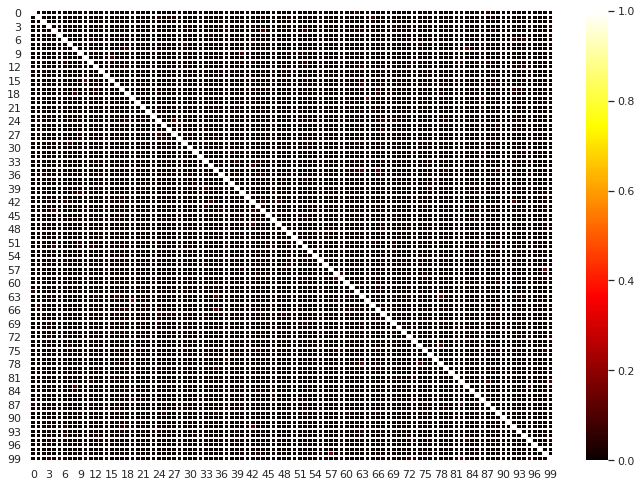

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(cosine_sim[0:100,0:100], linewidth=0.5,cmap='hot' )
#plt.show()

#plt.imshow(cosine_sim[0:100,0:100], cmap='hot', interpolation='nearest')
plt.show()

In [56]:
#Lấy danh sách tên các bộ film
indices = pd.Series(data.index,index=data['original_title'])
indices

original_title
Margaret Cho: PsyCHO                                                         0
Hamlet at Elsinore                                                           1
Gli invincibili tre                                                          2
The Secret of Blood Island                                                   3
Reiruweizu: 49-sai de densha no untenshi ni natta otoko no monogatari        4
                                                                         ...  
Deadpool                                                                 42223
The Avengers                                                             42224
Avatar                                                                   42225
The Dark Knight                                                          42226
Inception                                                                42227
Length: 42228, dtype: int64

Xây dựng một hàm đưa vào tên của một bộ film sau đó dựa vào ma trận cosine_sim để xác định 15 bộ film có độ tương đồng cao theo thứ tự giảm dần.

* input: title, cosine_sim
* output: list 15 film similarity


In [59]:
def get_recommend_movies(title,cosine_sim=cosine_sim):
    #Lấy index của bộ film theo tiêu đề đưa vào
    idx=indices[title]
    #Lấy điểm tương đồng theo cặp của tất cả các movies theo tiêu đề bộ film đưa vào
    sim_scores = list(enumerate(cosine_sim[idx]))
    #Sắp xếp các bộ film dựa theo điểm tương đồng
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    #Lấy điểm của 15 bộ film có độ tương đồng cao nhất
    sim_scores_15 = sim_scores[1:16]
    #Lấy index tương ứng với 15 bộ film này
    movies_index = [i[0] for i in sim_scores_15]
    #trả ra tiêu đề của 15 bộ film
    return data['original_title'].iloc[movies_index]

In [60]:
#Thử đề xuất với tên bộ film bất kỳ
#1. Bộ film: Batman Forever
get_recommend_movies('Batman Forever')

42216                                The Dark Knight Rises
38137                                    Batman: Bad Blood
31714                Batman: Return of the Caped Crusaders
42226                                      The Dark Knight
39888              Batman: The Dark Knight Returns, Part 1
38544                         Batman: Mask of the Phantasm
42200                                        Batman Begins
26107    Batman Unmasked: The Psychology of the Dark Kn...
32342                             Batman Beyond: The Movie
21743                                        Batman & Bill
41614                                       Batman Returns
16243                                      Pillow of Death
37620                   Batman Beyond: Return of the Joker
40083                           Batman: Under the Red Hood
27200    LEGO DC Comics Super Heroes: Batman: Be-Leaguered
Name: original_title, dtype: object

In [61]:
#Thử đề xuất với tên bộ film bất kỳ
#2. Bộ film: The Shawshank Redemption
get_recommend_movies('The Shawshank Redemption')

16901            They Made Me a Fugitive
11363                        Civil Brand
492                    Sette volte sette
32144                        Brute Force
3336                          زندان زنان
35424                            In Hell
13505                    Girls in Prison
19485         Blade Violent - I violenti
26146    Joshuu sasori: Dai-41 zakkyo-bô
4247        Ammazzali tutti e torna solo
2964                     Alcatraz Island
15052               The Domino Principle
13075              The Farm: Angola, USA
28137              Letters From a Killer
15580           Frauen für Zellenblock 9
Name: original_title, dtype: object

In [62]:
#Thử đề xuất với tên bộ film bất kỳ
#3. Bộ film: Star Wars
get_recommend_movies('Star Wars')

42164                              The Empire Strikes Back
35538                        The Star Wars Holiday Special
42205                         Star Wars: The Force Awakens
42109                                   Return of the Jedi
3443                      Maciste alla corte del Gran Khan
22381                                         Mad Dog Time
13356                                  The Triumph of Love
3351                                           Dao bing fu
32827    1½ Ritter - Auf der Suche nach der hinreißende...
38853                                    The Swan Princess
23239                                  Le royaume des fées
40094                                 Hot Shots! Part Deux
1409                                         Не покидай...
22227                                   Threads of Destiny
24387                                      Deathstalker II
Name: original_title, dtype: object

### B) Dựa vào Diễn viên, đạo diễn, keywords và thể loại film
---
Recommender System này sẽ xây dựng một hệ thống đề xuất (thuộc nhóm Content-Based Recommender) sử dụng sự tương đồng về các thông tin như 3 Diễn viên chính của film, đạo diễn film, 3 keywords của film và thể loại của film

* Phương pháp vecter hóa sử dụng là **CountVectorizer()**

Thông tin về diễn viên, đạo diễn, keyword, thể loại nằm trong dataset: credits, keywords

In [ ]:
#Thực hiện mount tới drive chứa file dữ liệu của Project
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

import pandas as pd
#Đọc tập dữ liệu thông tin của các film
path_movie='/content/drive/My Drive/Colab Notebooks/10Project/Data6_RecommenderSystem/movies_metadata.csv'
path_credits='/content/drive/My Drive/Colab Notebooks/10Project/Data6_RecommenderSystem/credits.csv'
path_keywords='/content/drive/My Drive/Colab Notebooks/10Project/Data6_RecommenderSystem/keywords.csv'
data_movie = pd.read_csv(path_movie)
data_credits = pd.read_csv(path_credits)
data_keywords = pd.read_csv(path_keywords)

In [ ]:
data_credits.info()

In [ ]:
data_credits.head()

In [ ]:
data_keywords.info()

In [ ]:
data_keywords.head()

In [ ]:
print(data_keywords.iloc[0,1])

In [ ]:
data_movie.isnull().sum()

In [ ]:
data_movie.iloc[19730,:]

In [ ]:
data_movie[data_movie['title'].isnull()]['title']

In [ ]:
#Drop một số rows trong dataset: Movies (dòng có cột ID ko phải số)
data_movie.drop([19730,29503,35587],inplace=True)

In [ ]:
#Chuyển đổi dữ liệu thuộc tính ID trong dataset Movie, Credits và Keywords về dạng số nguyên
data_credits['id'] = data_credits['id'].astype(int)
data_keywords['id'] = data_keywords['id'].astype(int)
data_movie['id'] = data_movie['id'].astype(int)

In [ ]:
#Ghép dữ liệu data của credits và keywords vào data của movie thành một Dataframe chính
data_movie = data_movie.merge(data_credits,on='id')
data_movie=data_movie.merge(data_keywords,on='id')
data_movie.info()

In [ ]:
data_movie.head()

Dữ liệu tại các thuộc tính cast, crew và keywords có dạng tập hợp từ điển, do vậy cần phải tách lấy 3 thành phần quan trọng trong đó bao gồm:
* actors (3 diễn viên chính trong film)
* director (đạo diễn của film)
* keywords (từ khóa liên kết)

In [ ]:
from ast import literal_eval

features = ['cast','crew','keywords','genres']
for feature in features:
    data_movie[feature] = data_movie[feature].apply(literal_eval)
data_movie.info() 

In [ ]:
data_movie.iloc[0,:]

In [ ]:
import numpy as np
#Hàm get_director thực hiện việc lấy ra tên của đạo diễn film, 
#trong trường hợp không có dữ liệu sẽ trả về NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
#Hàm get_list: trả về danh sách 3 phần tử đầu tiên hoặc danh sách rỗng
# Mỗi thuộc tính cast, keywords và genres chỉ lấy tối đa 3 phần tử.
def get_list(x):
    if isinstance(x,list):
        names=[i['name'] for i in x]
        #Nếu nhiều hơn 3 phần tử, chỉ lấy 3 phần tử đầu tieen; nếu ko có trả về rỗng
        if len(names)>3:
            names=names[:3]
        return names
    return[]
               

In [ ]:
data_movie['director'] = data_movie['crew'].apply(get_director)

features=['cast','keywords','genres']
for feature in features:
    data_movie[feature] = data_movie[feature].apply(get_list)

In [ ]:
data_movie[['title','cast','director','keywords','genres']].head()

Thực hiện chuyển đổi các tên và keyword toàn bộ về chữ thường và loạn bỏ các khoảng trắng giữa chúng. việc này sẽ đảm bảo khi thực hiện vector hóa không đếm Johnny của "Johnny Depp" và "Johnny Galecki" như nhau. Sau khi thực hiện bước xử lý này các diễn viên trước đây sẽ được thể hiện lại như là "johnnydepp" và "johnnygalecki" và sẽ là khác biệt khi vector hóa.

In [ ]:
#Hàm clean_data sẽ thực hiện việc chuyển về chữ thường, và cắt khoảng trắng giữa các tên
def clean_data(x):
    #Nếu là danh sách các tên, thực hiện xử lý lần lợt từng tên
    if isinstance(x,list):
        return [str.lower(i.replace(" ","")) for i in x]
    else:
        #Nếu chỉ có một tên
        if isinstance(x,str):
            return str.lower(x.replace(" ",""))
        else:
            return ''

In [ ]:
#Thực hiện hàm clean_data cho các thuộc tính
features = ['cast','keywords','director','genres']

for feature in features:
    data_movie[feature] = data_movie[feature].apply(clean_data)

#Kết quả sau khi clean_data
data_movie[['title','cast','director','keywords','genres']].head()

Tạo một thuộc tính tổng hợp tất cả các thuộc tính mà chúng ta muốn Recommender System sử dụng để đề xuất film: Với hệ thống này chúng ta sẽ đưa ra danh sách các film có độ tương đồng về diễn viên, đạo diễn, từ khóa và thể loại film

In [ ]:
#Hàm create_summary sẽ thực hiện việc ghép các từ trong các thuộc tính 
#keywords, cast, director, genres tạo thành một thuộc tính tổng hợp theo thứ tự đó.
def create_summary(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast'])+ ' ' + x['director'] + ' ' + ' '.join(x['genres'])

In [ ]:
#Tạo ra một thuộc tính tổng hợp mới
data_movie['metadata'] = data_movie.apply(create_summary,axis=1)

#Kết quả sau khi tổng hợp dữ liệu
data_movie[['title','cast','director','keywords','genres','metadata']].head()

In [ ]:
print(data_movie[['metadata']].head())

In [ ]:
#Lưu file csv dữ liệu [['title','cast','director','keywords','genres','metadata']]
data_filter=data_movie[['title','cast','director','keywords','genres','metadata']]
data_filter.shape

In [ ]:
#Lọc một số bộ film có tiêu đề null
data_filter[data_filter['title'].isnull()]

In [ ]:
#loại bỏ các bộ film này
data_filter.drop([19919,29714,36000,36001],inplace=True)

In [ ]:
#Lưu dữ liệu ra file .csv
data_filter.to_csv('data_filter.csv',index=None)

Tương tự như với hệ thống đề xuất dựa trên tóm tắt nội dung film đã xây dựng trong phần 2.2; bước tiếp theo cần  thực hiện vector hóa dữ liệu metadata; Với danh sách là các tên chúng ta sẽ sử dụng phương pháp CountVectorizer() thay cho phương pháp TF-IDF như trong 2.2. 

In [ ]:
#Thực hiện mount tới drive chứa file dữ liệu của Project
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

import pandas as pd
#Đọc tập dữ liệu thông tin của các film
path='/content/drive/My Drive/Colab Notebooks/10Project/Data6_RecommenderSystem/data_filter.csv'
data_filter = pd.read_csv(path)
data_filter.head()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(data_filter['metadata'])

count_matrix.shape

In [ ]:
#Tính toán độ tương đồng dựa theo Cosine với count_matrix đã xác định được
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix,count_matrix)

cosine_sim2.shape

In [ ]:
data_filter = data_filter.reset_index()
indices = pd.Series(data_filter.index, index=data_filter['title'])

In [ ]:
indices

In [ ]:
#Sử dụng lại hàm get_recommend_movies tương tự như trong 2.2
def get_recommend_movies_2(title,cosine_sim=cosine_sim2):
    #Lấy index của bộ film theo tiêu đề đưa vào
    idx=indices[title]
    #Lấy điểm tương đồng theo cặp của tất cả các movies theo tiêu đề bộ film đưa vào
    sim_scores = list(enumerate(cosine_sim[idx]))
    #Sắp xếp các bộ film dựa theo điểm tương đồng
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    #Lấy điểm của 15 bộ film có độ tương đồng cao nhất
    sim_scores_15 = sim_scores[1:16]
    #Lấy index tương ứng với 15 bộ film này
    movies_index = [i[0] for i in sim_scores_15]
    #trả ra tiêu đề của 15 bộ film
    return data_filter['title'].iloc[movies_index]

In [ ]:
#Thử đề xuất với tên bộ film bất kỳ
get_recommend_movies_2('Batman Forever')

In [ ]:
get_recommend_movies_2('The Dark Knight Rises')

In [ ]:
get_recommend_movies_2('The Godfather')

[More.................](https://github.com/rounakbanik/movies/blob/master/movies_recommender.ipynb)